In [1]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
import pandas as pd

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from sklearn.utils import resample

def explained_variance_with_bootstraping(X: pd.DataFrame, y: pd.Series, n_bootstraps=1000) -> (float, float):
    """
    Calculate the explained variance and its error bar for a GLM with a binary response variable.
    
    Args:
    X (pd.DataFrame): The feature values.
    y (pd.Series): The response labels, with 'R' for response and 'NR' for no response.
    n_bootstraps (int): Number of bootstrap samples to use for estimating the error bar.
    
    Returns:
    float, float: The pseudo R-squared for the model and the standard deviation of the EV from bootstrap samples.
    """
    # Original calculation
    label_encoder = LabelEncoder()

    # Bootstrap for error bar estimation
    ev_samples = []
    for _ in range(n_bootstraps):
        X_resampled, y_resampled = resample(X, y)
        y_encoded_resampled = label_encoder.fit_transform(y_resampled)
        X_with_intercept_resampled = sm.add_constant(X_resampled)
        glm_binom_resampled = sm.GLM(y_encoded_resampled, X_with_intercept_resampled, family=sm.families.Binomial())
        glm_result_resampled = glm_binom_resampled.fit()
        ev_samples.append(glm_result_resampled.pseudo_rsquared())

    
    return ev_samples

In [2]:
! pip install seaborn==0.11.2

In [2]:
def explained_variance_with_loo(X: pd.DataFrame, y: pd.Series, n_bootstraps=1000) -> (float, float):
    """
    Calculate the explained variance and its error bar for a GLM with a binary response variable.
    
    Args:
    X (pd.DataFrame): The feature values.
    y (pd.Series): The response labels, with 'R' for response and 'NR' for no response.
    n_bootstraps (int): Number of bootstrap samples to use for estimating the error bar.
    
    Returns:
    float, float: The pseudo R-squared for the model and the standard deviation of the EV from bootstrap samples.
    """
    # Original calculation
    label_encoder = LabelEncoder()

    from sklearn.model_selection import LeaveOneOut
    
    ev_samples = []
    loo = LeaveOneOut()
    for sidx, _ in loo.split(range(len(X))):
        X_resampled, y_resampled = X.iloc[sidx], y.iloc[sidx]
        y_encoded_resampled = label_encoder.fit_transform(y_resampled)
        X_with_intercept_resampled = sm.add_constant(X_resampled)
        glm_binom_resampled = sm.GLM(y_encoded_resampled, X_with_intercept_resampled, family=sm.families.Binomial())
        glm_result_resampled = glm_binom_resampled.fit()
        ev_samples.append(glm_result_resampled.pseudo_rsquared())
    
    return ev_samples

The calculation of feature explained variance (EV) quantifies the proportion of the total variance in the response variable that is attributable to each feature in the dataset, essentially measuring the strength of the relationship between the feature and the response. This is achieved by fitting a statistical model, like a logistic regression for binary outcomes, where the EV is often represented by pseudo R-squared values. These values indicate how well a feature explains the variance in the outcome, with higher values signifying greater explanatory power. To assess the reliability of these estimates, error bars are generated through methods like bootstrapping, where the original dataset is repeatedly resampled with replacement to create a distribution of EV estimates for each feature. The variability (standard deviation) or range (confidence interval) of these bootstrap estimates provides a measure of the error or uncertainty, offering insights into the stability and precision of the feature’s explained variance in predicting the response variable.

In [3]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

In [4]:
sns.__version__

'0.12.2'

In [5]:
import sys

sys.path.insert(0,  '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, plot_performance, score2
from conceptor.tokenizer import CANCER_CODE
def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [6]:
pwd

'/home/was966/Research/mims-conceptor/paper/07_shap_imp/03_BLCA_IMVigor210/FFT'

In [7]:
from conceptor.tokenizer import CONCEPT_palette

In [8]:
model = loadconceptor('./finetuner.pt')

## read data
df_label = pd.read_pickle('/home/was966/Research/mims-conceptor/paper//00_data/ITRP.PATIENT.TABLE')
df_tpm = pd.read_pickle('/home/was966/Research/mims-conceptor/paper//00_data/ITRP.TPM.TABLE')
df_tpm.shape, df_label.shape

((1133, 15672), (1133, 110))

In [9]:
df_label.groupby(['cancer_type', 'cohort']).size()

cancer_type  cohort     
BLCA         IMVigor210     298
             Rose            89
             Snyder          21
GBM          Zhao            25
KIRC         Choueiri        16
             IMmotion150    165
             Miao            17
LUAD         SU2CLC1        102
LUSC         SU2CLC2         25
SKCM         Allen           39
             Gide            73
             Hugo            26
             Liu            107
             MGH             34
             Riaz            51
STAD         Kim             45
dtype: int64

In [10]:
s = df_label.groupby('cohort').size()
cohorts = ['IMVigor210']

cohort_name = '_'.join(cohorts)
df_label = df_label[df_label.cohort.isin(cohorts)]

cancer_type = '_'.join(df_label.cancer_type.unique())
cohort_name = cancer_type + ':' + cohort_name

df_tpm = df_tpm.loc[df_label.index]

In [11]:
dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
df_task = onehot(df_label.response_label)

In [12]:
size = df_label.groupby('cohort').size()
size = size.index + '(n=' + size.astype(str) + ')'
size

cohort
IMVigor210    IMVigor210(n=298)
dtype: object

In [13]:
dfg, dfc = model.extract(dfcx, batch_size = 16)

100%|##########| 19/19 [00:09<00:00,  1.95it/s]


In [14]:
dfc = dfc[dfc.columns[1:]]

In [15]:
dfc.join(df_label.response_label).to_csv('DATA0_%s.csv' % (cohort_name))

In [16]:
res = []
dfx = dfc.loc[df_label.index]
for col in dfx.columns:
    X = dfx[[col]]
    y = df_label.response_label.loc[X.index]
    var = explained_variance_with_loo(X, y)
    res.append({'feature':col, 'exvar':var})

/tmp/ipykernel_25582/29561754.py:20: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dfp, x = x, y = y, order = x_order, palette=CONCEPT_palette,size=1, zorder=0.5) #, fliersize = 0
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 44.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 46.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 50.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/was966/micromamba/env

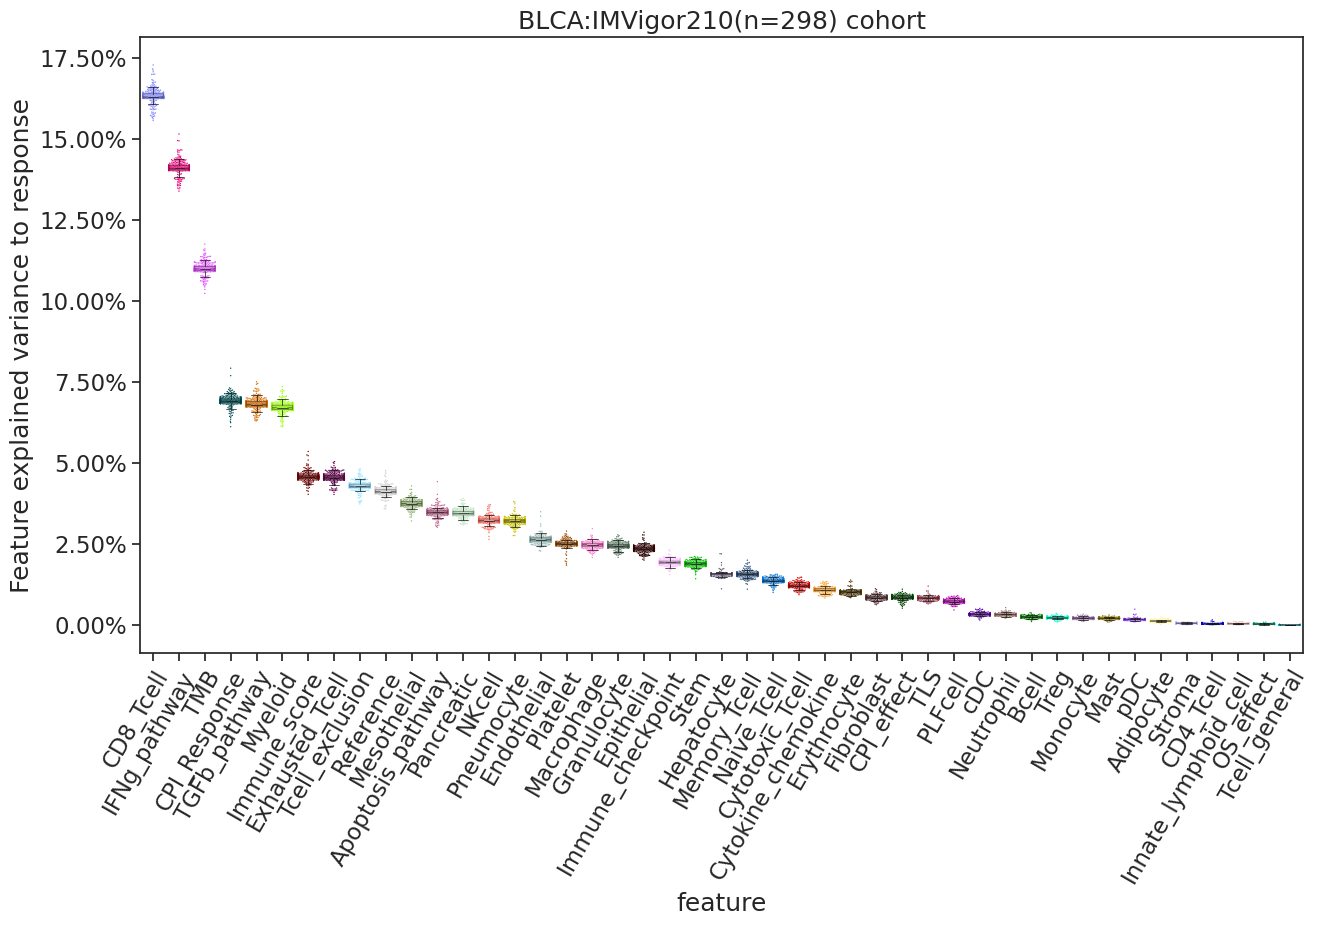

In [17]:
df1 = pd.DataFrame(res)

dfp = df1.set_index('feature').exvar.apply(pd.Series).unstack().reset_index()
dfp.columns = ['loo_sample','feature', 'exvar']

x = 'feature'
y = 'exvar'

x_order = dfp.groupby(x)[y].median().sort_values(ascending=False).index

bad = CONCEPT_palette['Reference']
good = CONCEPT_palette['Stem']
color_map = pd.Series(range(len(x_order)),index=x_order)
color_map = (color_map < color_map['Reference']).map({True:good, False:bad}).to_dict()

fig, ax = plt.subplots(figsize = (15,8))

sns.boxplot(data = dfp, x = x, y = y, order = x_order, palette=CONCEPT_palette, 
            fliersize = 0, notch=True, linewidth=0.5,  boxprops=dict(alpha= 0.5)) #, fliersize = 0 
sns.swarmplot(data = dfp, x = x, y = y, order = x_order, palette=CONCEPT_palette,size=1, zorder=0.5) #, fliersize = 0 

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
ax.set_xticklabels(x_order, 
                    rotation=60, 
                    ha="right",  
                    rotation_mode="anchor")  # <====== HERE is the ke
ax.set_ylabel('Feature explained variance to response')

ax.set_title('%s(n=%s) cohort' % (cohort_name, len(df_label)))

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

fig.savefig('FFT_rank_%s.pdf' % (cohort_name), bbox_inches  ='tight', dpi=300)
dfp.to_csv('DATA1_%s.csv' % (cohort_name))

In [18]:
selected_feature = list(x_order[:5])
if 'Reference' not in selected_feature:
    selected_feature.append('Reference')

da = dfc[selected_feature] #.join(df_label.response_label)
da = da.unstack().reset_index()
da.columns = ['feature', 'Index', 'score']
da = da.set_index('Index')
da['response_label'] = da.index.map(df_label.response_label)

da.to_csv('DATA2_%s.csv' % (cohort_name))

In [19]:
from itertools import chain
from statannotations.Annotator import Annotator

/tmp/ipykernel_25582/2118037124.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dat, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:9.086e-13 U_stat=1.228e+04


/tmp/ipykernel_25582/2118037124.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dat, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:7.877e-11 U_stat=3.760e+03


/tmp/ipykernel_25582/2118037124.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dat, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:2.190e-08 U_stat=4.326e+03


/tmp/ipykernel_25582/2118037124.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dat, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:2.753e-05 U_stat=1.044e+04


/tmp/ipykernel_25582/2118037124.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dat, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:1.117e-05 U_stat=1.056e+04


/tmp/ipykernel_25582/2118037124.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dat, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:4.209e-04 U_stat=5.618e+03


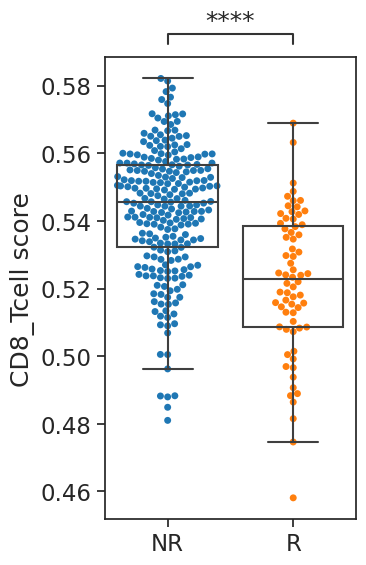

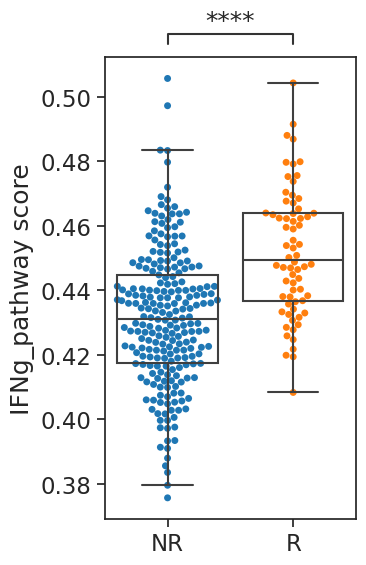

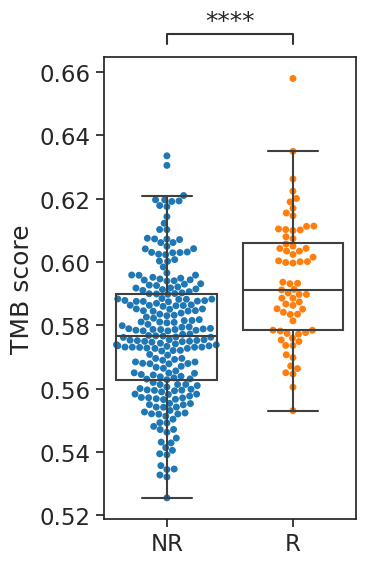

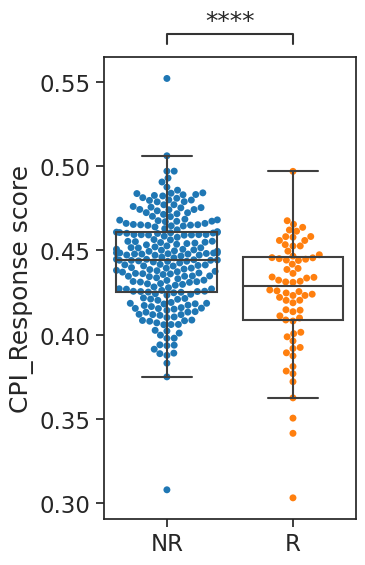

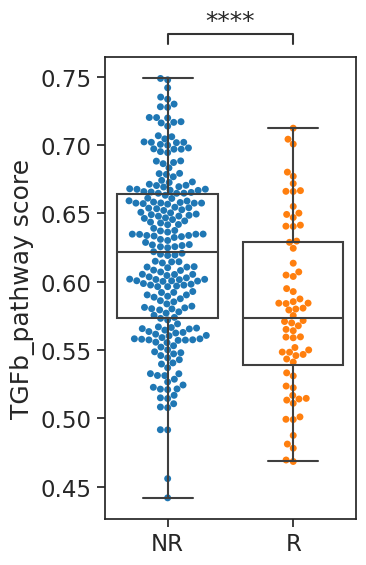

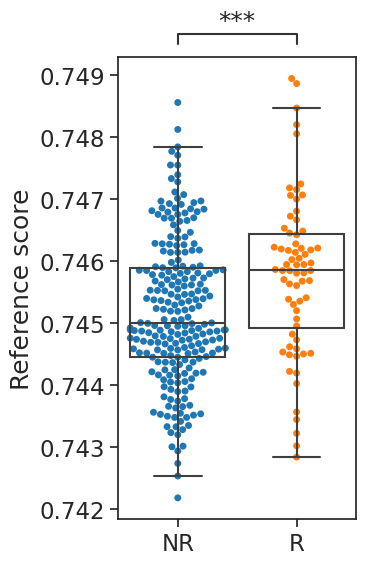

In [20]:
feature = selected_feature[1]

for feature in selected_feature:
    order = ['NR', 'R']
    cm = sns.palettes.color_palette('tab10', 4)
    palette = {'R':cm[1], 'NR':cm[0]}
    
    x = 'response_label'
    y = 'score'
    box_pairs = [('NR', 'R')]
    
    dat = da[da.feature == feature]
    
    fig, ax = plt.subplots(figsize=(4, 6))
    
    sns.boxplot(data = dat, x = x, y = y, fliersize = 0, width = .8, ax=ax, order = order, palette=palette, boxprops={'facecolor':'None'})
    sns.swarmplot(data = dat, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)
    
    annotator = Annotator(ax, pairs=box_pairs, data=dat, x=x, y=y, order=order)
    annotator.configure(test='Mann-Whitney', text_format='star',  loc='outside', comparisons_correction = None,)
    annotator.apply_and_annotate()
    
    ax.set_xlabel('')
    ax.set_ylabel('%s score' % feature)

    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    #ax.spines[['right', 'top']].set_visible(False)
    
    fig.tight_layout()

    fig.savefig('%s_%s.jpg' % (cohort_name, feature), bbox_inches  ='tight', dpi=300)